# Introduction

For this workbook, we are going to look at some flight data. With this data, we are going to take you through what it might look like to ingest, process, and utilize this data to derive some insights. 

To give some background on the data: 

This data comes a combination of two systems, the Airport Surface Detection Equipment (ASDE-X) and Airport Surface Surveillance Capability (ASSC). These two systems essentially track the movement of vehicles on the surface of an airport. More information regarding these two system can be found here: https://www.faa.gov/nextgen/programs/adsb/atc/assc/ and https://www.faa.gov/air_traffic/technology/asde-x/. We will be working with a slightly simplified set of data coming from these two systems. 

The time period of this data is from 8-1-2020 to 9-1-2020. 

# Ingesting Data + Prep

In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import datetime

In [2]:
# Ingest Data

# Change path name to '/home/jovyan/data/flight_data.csv' when online
df = pd.read_csv(r'C:\Users\jpau\Documents\Projects\Airforce\data\flight_data.csv')

# Basic Info

First, let's see what kind of data we are working with. Let's look at how much data we are working with, what kind of attributes we have, and finally we are the types of data stored in these attributes.

In [3]:
print("Shape of DF: ", df.shape)

Shape of DF:  (2489363, 11)


So at first glance, we see that there are around ~309,000 different flight observations with each flight have 13 different attributes associated with it. Let's see what the attributes are.

In [4]:
print("Column Types of DF: ", df.dtypes)

Column Types of DF:  Unnamed: 0              int64
airport                object
track                   int64
stid                    int64
call_sign              object
time                   object
event                  object
status                 object
departure_airport      object
destination_airport    object
timestamp              object
dtype: object


Okay, so at first glance. we can see that most of the data that we have to work with are objects, in other words strings, while there are a few columns that seem to be numbers, namely track and stid. 

Next, let's actually look at a snippet of the data. 

In [5]:
df.head()

,Unnamed: 0,airport,track,stid,call_sign,time,event,status,departure_airport,destination_airport,timestamp
0,0,KMIA,2088,9375251,UAL2081,2020-01-01 00:00:07,on,onsurface,KORD,KMIA,2020-01-01 00:00:00
1,1,KPIT,3534,339554,SWA4052,2020-01-01 00:00:08,off,airborne,NaN,NaN,2020-01-01 00:00:00
2,2,KMSY,4057,68290,SWA5830,2020-01-01 00:00:08,on,onsurface,NaN,NaN,2020-01-01 00:00:00
3,3,KMEM,3263,515627,AAL1996,2020-01-01 00:00:09,on,onsurface,KDFW,KMEM,2020-01-01 00:00:00
4,4,KDFW,683,1390176,AAL2346,2020-01-01 00:00:11,on,onsurface,KORD,KDFW,2020-01-01 00:00:00


So after taking a quick peek at the data, there are some observations that can be made. Namely, it seems that each observation represents an flight, uniquely labeled by the columns "stid". Moreover, each observation records seems to either record a single leg trip, showing whole trip but only recording the landing or taking off in the "event" column. Finally, it seems the "timestamp" column is the nearest hour of the "time" column. 

# Missing Data

Next, let's see if this data is complete. Often, datasets that we get will have unclean and missing data. So, often the first step in understanding the data is to explore and handle these unclean and missing data.

In [6]:
# Missing Info
df.isnull().sum()

Unnamed: 0                  0
airport                     0
track                       0
stid                        0
call_sign                   0
time                        0
event                   49787
status                      0
departure_airport      222797
destination_airport    222797
timestamp                   0
dtype: int64

So it seems the only missing data are the departure and destination airports for a portion of the data. While we can impute the either the departure or destination airports, incomplete flights are not that useful. So we will remove them. Moreover, this data is derived from the SFDPS flight plan data, therefore there might be a problem that we cannot control. So while this is a significant portion of the data, for this exercise, let us get drop these missing values. 

In [7]:
df = df[df['departure_airport'].notnull()]

In [ ]:
# impute data ????

# Cleaning the data

So from the data it seems that the airport column should be the same as the departure or destination airport columns depending on whether it is a take off or landing. However there are some exceptions. There are cases in which this is not the case. 

eg. for a takeoff, the reporting airport should be the departure airport (and visa-versa). However, we see that there are a number of cases in which this is not the case. It may be an bad sensor or a mistake in reporting. In either case, let's look at these cases and decide what to do with them. 

In [8]:
df[(df['destination_airport'].notnull()) & (df['destination_airport'] == df['airport']) & (df['destination_airport'] != df['departure_airport']) & (df['event'] == 'off')][['airport','stid','call_sign','time','event','departure_airport','destination_airport']].head()

,airport,stid,call_sign,time,event,departure_airport,destination_airport
2838,KBWI,1423638,SWA2002,8/1/2020 13:26,off,KTPA,KBWI
6133,KEWR,4865228,UAL1600,8/1/2020 18:27,off,KFLL,KEWR
13976,KCLT,2046513,AAL2895,8/2/2020 16:09,off,KORD,KCLT
14702,KSAN,382922,DAL884,8/2/2020 17:20,off,KDTW,KSAN
19157,KMDW,1724099,SWA2214,8/2/2020 23:51,off,KLGA,KMDW


So we found all the takeoffs that didn't seem right. Can we do this for all the landing as well?

In [9]:
# Exercise Here

In [10]:
################
### Solution ###
################

df[(df['destination_airport'].notnull()) & (df['departure_airport'] == df['airport']) & (df['event'] == 'on') & (df['destination_airport'] != df['departure_airport'])][['airport','stid','call_sign','time','event','departure_airport','destination_airport']].head()

,airport,stid,call_sign,time,event,departure_airport,destination_airport
177,KJFK,10068693,DAL8786,8/1/2020 0:14,on,KJFK,MDST
945,KLAS,2251523,SWA460,8/1/2020 1:44,on,KLAS,KOAK
5067,KATL,8857217,DAL421,8/1/2020 16:51,on,KATL,TISX
5412,KHOU,810091,SWA3006,8/1/2020 17:24,on,KHOU,MMSD
5423,KLAS,2254717,SWA2366,8/1/2020 17:25,on,KLAS,KDAL


After inspection, we see that there only a small number of cases compared to the total amount of cases, so let's drop them because we don't have any additional information regarding them.

In [11]:
df = df[((df['destination_airport'] == df['airport']) & (df['event'] == 'on')) | 
       ((df['departure_airport'] == df['airport']) & (df['event'] == 'off'))]

Next though we know the dates for the data, we should double check. So let's see what the dates of the data are. 

In [12]:
print('First event:', df['time'].min())
print(' Last event:', df['time'].max())

First event: 7/31/2020 23:58
 Last event: 8/9/2020 9:59


In [13]:
df[df['time'] < '8/1/2020']['airport'].count()

18

So we see that there are some events that occur before August 1st even though its a couple minutes before August 1st. Though it doesn't necessarily mean significantly impact the data in any way, let us clean this data so that it is consistent. 

In [14]:
df = df[df['time'] >= '8/1/2020']

# EDA

Now that we have done some clean up, let's explore the data. The first thing that is of interest is the airports. 

In [15]:
# US Airport Names
print(df['airport'].unique())

['KDFW' 'KORD' 'KATL' 'KMSP' 'KDEN' 'KSTL' 'KHOU' 'KIAH' 'KMDW' 'KMIA'
 'KCLT' 'KSAN' 'KLGA' 'KLAS' 'KPHL' 'KSLC' 'KDTW' 'KPVD' 'KBOS' 'KJFK'
 'KPHX' 'KLAX' 'KFLL' 'KDCA' 'KBWI' 'KSNA' 'KSEA' 'KMEM' 'KMCO' 'KEWR'
 'KMKE' 'KIAD' 'KBDL' 'KSDF']


In [16]:
# Weird Airport Names
print(df['departure_airport'].unique())

['KDTW' 'KORD' 'KATL' 'KSEA' 'KIAD' 'KDEN' 'KMSP' 'KSTL' 'KHOU' 'KLGA'
 'KSMF' 'KMDW' 'KDAL' 'KMIA' 'KCLT' 'KPHL' 'KOAK' 'KGEG' 'KSAN' 'KDFW'
 'KSLC' 'KDCA' 'KIAH' 'KLAS' 'KIND' 'MMMX' 'KMCO' 'KPHX' 'KLAX' 'KOMA'
 'KBOS' 'KBWI' 'KSNA' 'KPDX' 'KFLL' 'KJFK' 'KBNA' 'KTUS' 'KMCI' 'KBOI'
 'KMYR' 'KSJC' 'KONT' 'KRSW' 'KCMH' 'KBHM' 'MMSD' 'KSAT' 'KBUR' 'KORF'
 'KAUS' 'KBDL' 'KEWR' 'KJAC' 'KELP' 'TJSJ' 'KTPA' 'KMKE' 'KMSY' 'KSFO'
 'RJAA' 'KTUL' 'KRDU' 'KOKC' 'MDPC' 'KFAT' 'MMUN' 'KPNS' 'KPIT' 'MROC'
 'KMEM' 'KSDF' 'PANC' 'MSLP' 'MMPR' 'KABQ' 'KVCV' 'KMZJ' 'KGRR' 'LIMC'
 'LIRF' 'MGGT' 'KRNO' 'KCOS' 'EGLL' 'SPJC' 'KDAB' 'PHNL' 'PGUM' 'LLBG'
 'VIDP' 'VABB' 'SBGR' 'SAEZ' 'KPVD' 'SEGU' 'KSAV' 'KJAX' 'KGSP' 'KGSO'
 'KCHS' 'KAGS' 'KISP' 'KMLB' 'MDSD' 'KSRQ' 'KALB' 'KMHT' 'KRIC' 'KROC'
 'KCLE' 'KBUF' 'KPWM' 'PHKO' 'PHOG' 'SEQM' 'KSYR' 'KCVG' 'KMDT' 'KECP'
 'KPBI' 'KLIT' 'KCHA' 'KHRL' 'KEYW' 'RJTT' 'KMSN' 'KICT' 'KCRP' 'KDSM'
 'KTLH' 'PAFA' 'KMAF' 'KVPS' 'YSSY' 'RKSI' 'KATW' 'KBZN' 'KILM' 'KCAE'
 'KBIL

The first we notice is that in the airport column, there are only US airports as indicated by the 'K' as the first character in the airport name. However, in the departure and destination airport columns, we see a whole host of airports from around the world. That makes sense because we are only looking at american based airlines who tend to operate in the US. We can use this knowledge to create a variable to determine if a flight is local or international which may be interesting to look at. 

We also see some weird names for airports. We can leave them for now since there is no way to verify what airports they belong to.

In [17]:
# Local or International Flights
df['type_of_flight'] = np.where((df['departure_airport'].str[0] == 'K') & (df['destination_airport'].str[0] == 'K'), 'local', 'international')

Next let's look at the call sign column. The call signs are used to identify themselves. We know that generally the first 3 characters of the call sign indicate which airlines they are from. So let's look at which airlines are represented here.

In [18]:
df['call_sign'].str[:3].unique()

array(['AAL', 'UAL', 'SWA', 'DAL'], dtype=object)

We see that there are 4 different airlines: United, Delta, Southwest and American Airlines. Let's make a separate column so that this data can be used later. 

In [19]:
df['airline'] = df['call_sign'].str[:3]

Another column worth looking at is the event column. It determines whether a flight is taking off or landing. 

In [20]:
df.groupby('event')['event'].count().reset_index(name = 'count')

,event,count
0,off,141869
1,on,142082


We see that there are more take-offs and landings. Though the numbers are pretty close. This makes sense. We arbitrary determined a starting and ending time meaning that we could have cut off some information of flights taking off and landing. Not too big of a concern.

For now, we can table looking at some of the other variables such as latitude, longitude, and altitude. They are not necessarily all that interesting for this exercise. 

Let's on exploring some of the actual flight data. One the best ways to do this is to ask questions to learn about the data. From there we can observe if there are any anomilies or interesting results that might be able to glean from the data.

### What are the busiest / most trafficked airports?

<BarContainer object of 10 artists>

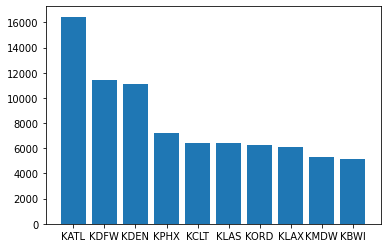

In [21]:
df_airports = df.groupby(['airport','event'])['airport'].count().reset_index(name = 'count').sort_values(['event','count'], ascending = False)

# Most Busy Airports in USA
plt.bar(df_airports[df_airports['event'] == 'on']['airport'].head(10), df_airports[df_airports['event'] == 'on']['count'].head(10))

Let's see this same data but broken down by airline.

In [22]:
df.groupby(['event','type_of_flight','airline'])['airport'].count().reset_index(name = 'count').sort_values(['event','count','type_of_flight','airline'], ascending = False)


,event,type_of_flight,airline,count
14,on,local,SWA,47444
12,on,local,AAL,36200
13,on,local,DAL,35491
15,on,local,UAL,15992
8,on,international,AAL,2469
9,on,international,DAL,2018
11,on,international,UAL,1994
10,on,international,SWA,474
6,off,local,SWA,47236
4,off,local,AAL,36172


In [23]:
df.groupby(['type_of_flight'])['airport'].count()

type_of_flight
international     13976
local            269975
Name: airport, dtype: int64

So we found the busiest airports, but another piece of interesting information would be to find the most traveled flights both within the continental USA and outside of it. Let's see if we can find the most common local and international flights.

In [24]:
# Exercise Here
# Local Flights

# Interational Flights

In [25]:
################
### Solution ###
################

# Most common Destination Pairs within continental USA
print(df[df['type_of_flight'] == 'local'].groupby(['departure_airport','destination_airport'])['airport'].count().reset_index(name = 'count').sort_values('count', ascending = False).head(5))

# Most Common Destination Pair outside of the continental USA
print(df[df['type_of_flight'] != 'local'].groupby(['departure_airport','destination_airport'])['airport'].count().reset_index(name = 'count').sort_values('count', ascending = False).head(5))

     departure_airport destination_airport  count
553               KDEN                KLAX    925
1135              KLAX                KDEN    903
636               KDFW                KLAX    851
1136              KLAX                KDFW    849
572               KDEN                KPHX    816
    departure_airport destination_airport  count
227              KLAX                PHNL    136
436              PHNL                KLAX    135
486              TJSJ                KMCO    127
236              KMCO                TJSJ    125
117              KDFW                MMUN    125


Another aspect of the flight that might be interesting to look at is when the flights happen. So let's explore that angle of the data. 

### What day of month do flights usually happen?

In [26]:
df['time'] = pd.to_datetime(df['time'])
df['day_of_flight'] = df['time'].dt.date

df_flight_time = df.groupby(['day_of_flight','type_of_flight'])['airport'].count().reset_index(name = 'count_of_flights')
df_local = df_flight_time[df_flight_time['type_of_flight'] == 'local'][['day_of_flight','count_of_flights']]
df_international = df_flight_time[df_flight_time['type_of_flight'] == 'international'][['day_of_flight','count_of_flights']]
     

C:\Users\jpau\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



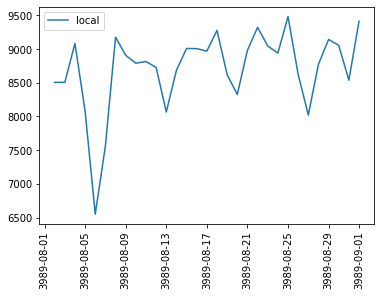

In [40]:

plt.plot(df_local['day_of_flight'], df_local['count_of_flights'],  label = 'local')
plt.legend()
plt.xticks(rotation=90)
plt.rcParams['date.epoch'] = '1970-01-01T00:00:00'
plt.show()

C:\Users\jpau\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



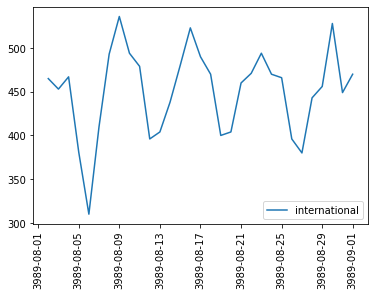

In [39]:
plt.plot(df_international['day_of_flight'], df_international['count_of_flights'],  label = 'international')
plt.xticks(rotation=90)
plt.legend()
plt.show()

So we see that in general there seems to be a similar number of flights per day, except for a drop in flights around 8/5/2020. That would be something interesting to investigate. 

Since both international flights and local flights occur over the same time period, let's see what happens when you plot them on the same graph. 

In [ ]:
# Exercise Here

C:\Users\jpau\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

C:\Users\jpau\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:245: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



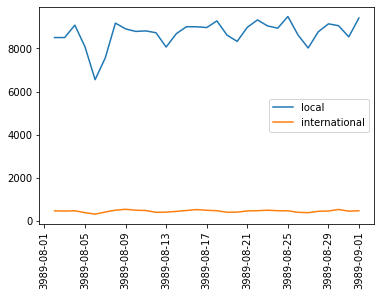

In [163]:
################
### Solution ###
################

plt.plot(df_local['day_of_flight'], df_local['count_of_flights'],  label = 'local')
plt.plot(df_international['day_of_flight'], df_international['count_of_flights'],  label = 'international')
plt.legend()
plt.xticks(rotation=90)
plt.show()

This combined graph is actually not as useful as the individual graphs. One thing to note is that when plotting the two different lines on the graph, the graph can yield very little information due to the difference in scale. In this case, we see that much of the noise from the international flights is obscured by the much higher volume of local flights. So what might be a better way to plot these two lines? 

One possible solution would to look at the proportions of flights by day. Let's represent this using a bar chart instead of a line graph. 

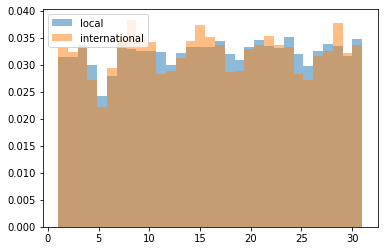

In [141]:
plt.hist(pd.to_datetime(df[df['type_of_flight'] == 'local']['time']).dt.day, label = 'local', weights=np.ones(len(df[df['type_of_flight'] == 'local']['time'])) / len(df[df['type_of_flight'] == 'local']['time']), alpha = .5, bins = 31)
plt.hist(pd.to_datetime(df[df['type_of_flight'] == 'international']['time']).dt.day, weights = np.ones(len(df[df['type_of_flight'] == 'international']['time'])) / len(df[df['type_of_flight'] == 'international']['time']), label = 'international', alpha = .5, bins = 31)
plt.legend()
plt.show()

In this chart, we see that the same information in the previous graphs presented differently. Instead of the absolute number of flights, we understand the proportion of flights as the month goes on. One thing that we notice is that international flights tend to fly much more often on the weekends than on the weekdays where as local flights tend to be more consistent throughout the month. 

### What about time of day?

Now that we have looked at how to look at flight by times during the month. How would we do this for the time of flights during the day? And what conclusion can we draw from the data?

In [ ]:
# Exercise Here

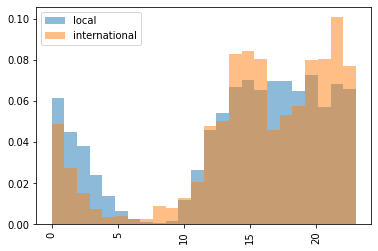

In [52]:
################
### Solution ###
################

plt.hist(pd.to_datetime(df[df['type_of_flight'] == 'local']['time']).dt.hour, label = 'local', weights=np.ones(len(df[df['type_of_flight'] == 'local']['time'])) / len(df[df['type_of_flight'] == 'local']['time']), alpha = .5, bins = 24)
plt.hist(pd.to_datetime(df[df['type_of_flight'] == 'international']['time']).dt.hour, weights = np.ones(len(df[df['type_of_flight'] == 'international']['time'])) / len(df[df['type_of_flight'] == 'international']['time']), label = 'international', alpha = .5, bins = 24)
plt.legend()
plt.show()

### Which airline is the best to fly on if you want a quick flight?

First, we need to match up the events to show only the flights with a complete flight record. Then we need to find the flight duration. Finally, we will be able to see which airline is the most consistently the fasted.  

In [45]:
# Sorting by Time so that we can match the flight records
df_flights = df.sort_values(['call_sign','time'])

# Creating additional columns to match flight records
df_flights['call_sign_shift'] = df_flights['call_sign'].shift(1)
df_flights['event_shift'] = df_flights['event'].shift(1)
df_flights['airport_shift'] = df_flights['airport'].shift(1)
df_flights['time_shift'] = df_flights['time'].shift(1)

# Filtering out all takeoffs so that we have a single record for each flight record
df_flights_2 = df_flights[(df_flights['event'] == 'on')].copy()
df_flights_3 = df_flights_2.loc[(df_flights_2['event'] != df_flights_2['event_shift']) & 
                                (df_flights_2['call_sign'] == df_flights_2['call_sign_shift']) & 
                                (df_flights_2['airport_shift'] == df_flights_2['departure_airport'])]


In [46]:
df_flights_3.loc[:, 'length_of_trip'] = (df_flights_3['time'].sub(df_flights_3['time_shift'])) / np.timedelta64(1, 'm')

# Dropping all unnecessary columns 
df_flights_3 = df_flights_3.drop(columns = ['call_sign_shift','event_shift','airport_shift','time_shift'])

Let's see the distribution of flight times for the different airlines to make a quick check that everything is done right. We can do this through a plot called a boxplot also sometimes known as a box and whisker plot. Basically, this plot visualizes a 5 number summary of the data. It shows the "minimum" (the first quartile minus 1.5 times the range between the first and third quartiles), first quartile (if you split the into 4 sections and ordered them and picked the boundary of the first and second ones), median, third quartile, and "maximum". These kinds of plots are good for understanding the distributino of number as well as identifying outliers in our data. 

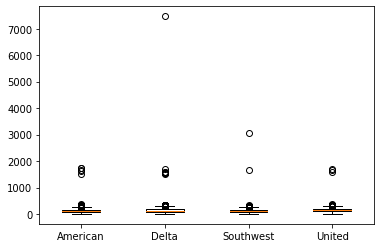

In [28]:
airline_aal = df_flights_3[df_flights_3['airline'] == 'AAL']['length_of_trip']
airline_dal = df_flights_3[df_flights_3['airline'] == 'DAL']['length_of_trip']
airline_swa = df_flights_3[df_flights_3['airline'] == 'SWA']['length_of_trip']
airline_ual = df_flights_3[df_flights_3['airline'] == 'UAL']['length_of_trip']

airline_boxplot = [airline_aal, airline_dal, airline_swa, airline_ual]
plt.boxplot(airline_boxplot, labels = ['American','Delta','Southwest','United']);

So we see something really interesting here. We see that there are a few flights that are taking significantly longer than supposed to. We know that the length_of_trip column is in minutes. So for a flight to take more than 1000 minutes which is more than 16 hours is highly unlikely. For some perspective, a flight from Seattle, WA to Miami, Fl takes about 6 hours which translates to 360 minutes. This clearly means something funky is going on in the data so let's look into it. 

In [29]:
df_flights_3[df_flights_3['length_of_trip'] > 1000].head()

,Unnamed: 0,airport,track,stid,call_sign,time,event,status,departure_airport,destination_airport,timestamp,type_of_flight,airline,length_of_trip
54316,54316,KPHX,2754,11701827,AAL1057,2020-08-06 23:11:09,on,onsurface,KBOS,KPHX,2020-08-06 23:00:00,local,AAL,1744.550000
53667,53667,KDFW,3899,2185669,AAL1094,2020-08-06 22:17:22,on,onsurface,KBOS,KDFW,2020-08-06 22:00:00,local,AAL,1641.566667
53103,53103,KDCA,578,2716436,AAL2146,2020-08-06 21:27:49,on,onsurface,KBOS,KDCA,2020-08-06 21:00:00,local,AAL,1520.700000
46626,46626,KLAX,558,11592710,AAL2289,2020-08-06 06:46:33,on,onsurface,KMIA,KLAX,2020-08-06 07:00:00,local,AAL,1733.033333
55149,55149,KLGA,2827,1327386,AAL2716,2020-08-07 00:24:08,on,onsurface,KDFW,KLGA,2020-08-07 00:00:00,local,AAL,1670.900000


Taking a sample of the data, makes it clear that these flights are not possible. One possibility of this would be that the other half of the flight was not recorded. Let us go and check in the data before removing them.

In [30]:
# look at original data

Yep, it seems like for some of these flights. There are parts of the trip that are not recorded. Let us remove these flights then and move on to finding the average flight time for the various destination/departure pairs. Let's also identify the 

In [31]:
df_flights_4 = df_flights_3[df_flights_3['length_of_trip'] < 1000].merge(df_flights_3[df_flights_3['length_of_trip'] < 1000].groupby(['destination_airport','departure_airport'])['length_of_trip'].mean().reset_index(name = 'avg_flight_length'), on= ['destination_airport','departure_airport'])
df_flights_4['adjusted_to_avg'] = df_flights_4['length_of_trip'] - df_flights_4['avg_flight_length']

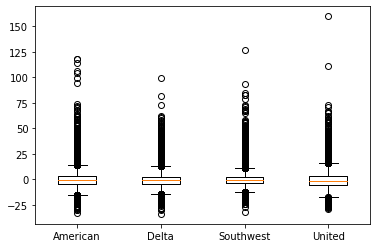

In [32]:
airline_aal = df_flights_4[df_flights_4['airline'] == 'AAL']['adjusted_to_avg']
airline_dal = df_flights_4[df_flights_4['airline'] == 'DAL']['adjusted_to_avg']
airline_swa = df_flights_4[df_flights_4['airline'] == 'SWA']['adjusted_to_avg']
airline_ual = df_flights_4[df_flights_4['airline'] == 'UAL']['adjusted_to_avg']

airline_boxplot = [airline_aal, airline_dal, airline_swa, airline_ual]
plt.boxplot(airline_boxplot, labels = ['American','Delta','Southwest','United']);

Looking at the box plot of the how flights compared to the average flight time. We against see bigger than expected outliers that we would want to explore. 

In [33]:
df_flights_4[(df_flights_4['airline'] == 'UAL') & (df_flights_4['adjusted_to_avg'] > 100)]

,Unnamed: 0,airport,track,stid,call_sign,time,event,status,departure_airport,destination_airport,timestamp,type_of_flight,airline,length_of_trip,avg_flight_length,adjusted_to_avg
54567,27390,KATL,2690,8959935,UAL307,2020-08-03 21:02:48,on,onsurface,KDEN,KATL,2020-08-03 21:00:00,local,UAL,307.266667,147.500177,159.766490
57244,257899,KDEN,143,4559905,UAL2493,2020-08-27 00:20:23,on,onsurface,KSEA,KDEN,2020-08-27 00:00:00,local,UAL,239.616667,128.517919,111.098747


In [34]:
df[(df['time'] < '08-04-2020') & (df['time'] > '08-03-2020') & (df['departure_airport'] == 'KDEN') & (df['destination_airport'] == 'KATL') & (df['call_sign'] == 'UAL307')].sort_values(['call_sign','time'])

,Unnamed: 0,airport,track,stid,call_sign,time,event,status,departure_airport,destination_airport,timestamp,type_of_flight,airline
23857,23857,KDEN,3939,4037660,UAL307,2020-08-03 15:55:32,off,airborne,KDEN,KATL,2020-08-03 16:00:00,local,UAL
27390,27390,KATL,2690,8959935,UAL307,2020-08-03 21:02:48,on,onsurface,KDEN,KATL,2020-08-03 21:00:00,local,UAL


Looking at one of the examples, it looks like the there doesn't seem to be anything wrong with the data. This indicates that this flight must have been just taken a much longer time. Maybe, delayed by something that happend at the destination airport. Now that we confirmed that the data makes sense. 

Let us return our original question, which airline is the best to fly on. Now, the best can refer to many things, two typical measurements that people use the word best might be either quickness or reliability. Let us look at both. 

In [35]:
df_quickness = df_flights_4.groupby('airline')['adjusted_to_avg'].mean().reset_index(name = 'avg_time')
df_reliable = df_flights_4.groupby('airline')['adjusted_to_avg'].std().reset_index(name = 'std_time')

df_best = df_quickness.merge(df_reliable, on = 'airline')

In [36]:
df_best

,airline,avg_time,std_time
0,AAL,0.190901,7.708061
1,DAL,-0.273114,6.657581
2,SWA,0.123937,6.378916
3,UAL,-0.118090,8.496612


As we can see, generally, Delta seems to perform above the average flight time it takes to fly a certain route, while Southwest seems ot have the least amount of variablity when it comes to the routes that it flies. There you go, the best airlines according to our data!

# Merging Data - IP

We also have another set of data that can be merged with our existing set that might make exploring this data much more interesting. It is the latitude, longtitude and altitudes of the airports! So let's see if there are any gems when we include this dataset. 

In [40]:
# Change path name to '/home/jovyan/data/flight_data.csv' when online
df_airport_desc = pd.read_csv(r'C:\Users\jpau\Documents\Projects\Airforce\data\airport_data.csv')

In [41]:
df_airport_desc.head()

,airport,latitude,longitude,altitude
0,KIAH,29.97775,-95.29970,150.00
1,KSEA,47.46886,-122.31785,512.50
2,KATL,33.64950,-84.40834,1100.00
3,KHOU,29.65113,-95.28578,93.75
4,KDEN,39.83214,-104.64171,5450.00


In [47]:
# Thrown on a map
df_map = df[['airport','latitude','longitude']].groupby('airport').mean().merge(df.groupby(['airport'])['airport'].count().reset_index(name="count"), on = 'airport')

fig = go.Figure(data=go.Scattergeo(
        lon = df_map['longitude'],
        lat = df_map['latitude'],
        text = df_map[['airport', 'count']],
        mode = 'markers',
        marker_color = df_map['count']
        ))

fig.update_layout(
        title = 'Most trafficked US airports',
        geo_scope='usa'
    )
fig.show()

KeyError: "['latitude', 'longitude'] not in index"

# Conlusion

So we have looked at this dataset. Discovered some interesting things about the data.